# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 2 in Shi Jin's paper:
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = (e^{-25(x-0.5)^2})^2, \ S_0(x) = 0.2(x^2 - x).
$$

Periodic BC.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25(x-0.5)^2}\cos(\frac{0.2(x^2-x)}{\varepsilon}), \ q(x, 0) = e^{-25(x-0.5)^2}\sin(\frac{0.2(x^2-x)}{\varepsilon}),
$$
and bc
$$
p(0, t) = p(1, t), q(0, t) = q(1, t), p_x(0, t) = p_x(1, t), q_x(0, t) = q_x(1, t).
$$

In [1]:
NAME = "1_siren"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(0)
key, subkey = random.split(key, 2)

layers = [2] + [128]*4 + [2] # (x, t) -> (u, v)
c0 = 1.0
w0 = 10.0
w1 = 1.0
lambda_0 = 1e-8
direct_params = init_siren_params(subkey, layers, c0, w0, w1)

domain = jnp.array([[0., 0.], [1., 1.]])
epsilon = 1.0
V = 1.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mse

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jit_conservation(2)
def loss_fn_(params, batch, conservation):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	uv_conservation = model(direct_params, jnp.hstack([conservation.x, conservation.t]))
	u_conservation, v_conservation = uv_conservation[:, 0:1].reshape((conservation.nt, conservation.nx)), uv_conservation[:, 1:2].reshape((conservation.nt, conservation.nx))
	norm_conservation = jnp.sum(jnp.square(u_conservation)+jnp.square(v_conservation), axis = 1)
	uv0_conservation = model(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
	u0_con, v0_con = uv0_conservation[:, 0:1].reshape((1, -1)), uv0_conservation[:, 1:2].reshape((1, -1))
	norm0_con = jnp.sum(jnp.square(u0_con) + jnp.square(v0_con))
	loss_conservation = metaloss(norm_conservation - norm0_con, 0)
	
	duv_dxt_conservation = jacobian(direct_params, jnp.hstack([conservation.x, conservation.t]))
	du_dx_conservation, dv_dx_conservation = duv_dxt_conservation[:, 0:1, 0].reshape((conservation.nt, conservation.nx)), duv_dxt_conservation[:, 1:2, 0].reshape((conservation.nt, conservation.nx))
	energy_conservation = (epsilon**2)/2*jnp.sum(du_dx_conservation**2+dv_dx_conservation**2, axis = 1) + V*norm_conservation
	duv0_dxt0_conservation = jacobian(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
	du0_dx0_conservation, dv0_dx0_conservation = duv0_dxt0_conservation[:, 0:1, 0].reshape((1, -1)), duv0_dxt0_conservation[:, 1:2, 0].reshape((1, -1))
	energy0_conservation = (epsilon**2)/2*jnp.sum(du0_dx0_conservation**2+dv0_dx0_conservation**2, axis = 1) + V*norm0_con
	loss_energy = metaloss(energy_conservation - energy0_conservation, 0)
	
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = metaloss(u_l, u_r)
	loss_pbc_d2 = metaloss(v_l, v_r)
	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy


@jit_conservation(2)
def loss_fn(params, batch, conservation):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy = loss_fn_(params, batch, conservation)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + w["conservation"]*loss_conservation + w["energy"]*loss_energy \
			+ l2_regularization(params, lambda_0)

@jit_conservation(3)
def step(i, opt_state, batch, conservation):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch, conservation)
	return opt_update(i, grad, opt_state)

@jit_conservation(2)
def evaluate(params, batch, conservation):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy = loss_fn_(params, batch, conservation)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + w["conservation"]*loss_conservation+ w["energy"]*loss_energy, \
			loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy

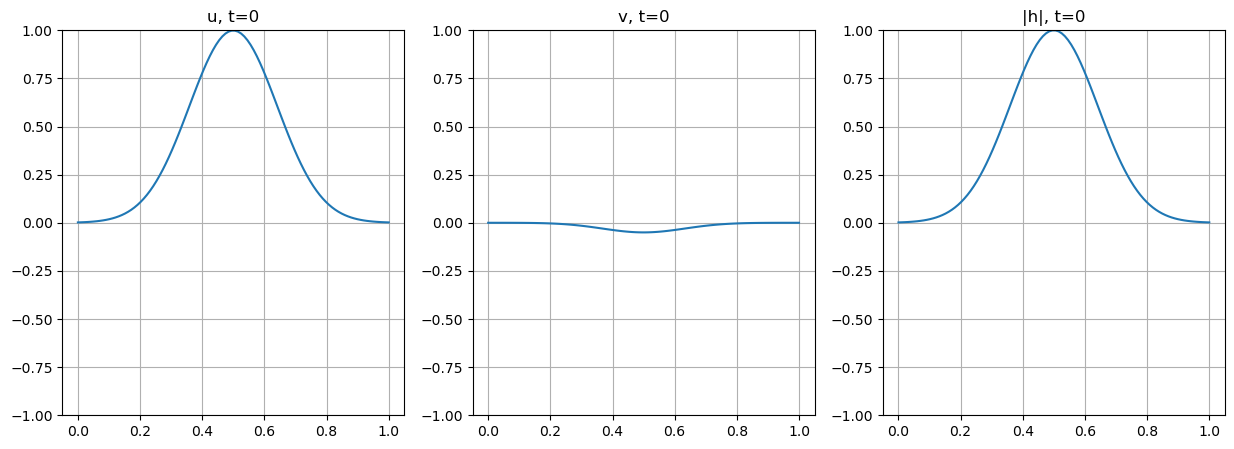

In [5]:
u0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.cos(0.2/epsilon*(x**2-x))
v0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.sin(0.2/epsilon*(x**2-x))
x0 = np.linspace(*domain[:, 0], 100)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 10000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 1000
t_b = random.uniform(subkeys[1], (n_b, 1), jnp.float32, *domain[:, 1])
x_lb = jnp.ones_like(t_b)*domain[0, 0]
x_rb = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 2000
n_ct = 200
x_c = jnp.linspace(*domain[:, 0], n_cx)
t_c = jnp.linspace(*domain[:, 1], n_ct)
xt_c = tensor_grid([x_c, t_c])

nx_conservation = 101
nt_conservation = 50
x_conservation = jnp.linspace(*domain[:, 0], nx_conservation)
t_conservation = jnp.linspace(*domain[:, 1], nt_conservation)
tx_conservation = tensor_grid([t_conservation, x_conservation])
x0_conservation = x_conservation
t0_conservation = jnp.array([domain[0, 1]])
tx0_conservation = tensor_grid([t0_conservation, x0_conservation])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])
dataset_Conservation = namedtuple("dataset_Conservation", ["x", "t", "nx", "nt", "x0", "t0"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
periodic_bc = dataset_BC(x_lb, x_rb, t_b)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, xt_c[:, 0:1]]),
								  jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, xt_c[:, 1:2]]))
conservation = dataset_Conservation(tx_conservation[:, 1:2], tx_conservation[:, 0:1], nx_conservation, nt_conservation, tx0_conservation[:, 1:2], tx0_conservation[:, 0:1])

In [6]:
lr = 1e-4
start_iteration = 0
iterations = 10000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 50000}
weights = {"c": 0.0, "d": 1.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 0.0, "energy": 0.0}

key, *subkeys = random.split(key, 4)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/04, 23:52:37, Iteration: 0, Train Loss: 1.4678e+00, c: 2.1987e+01, d: 2.0473e-01, pbc_d: 1.3849e-02, pbc_n: 1.2492e+00, conservation: 4.3158e-02, energy: 3.3827e+02
2020/08/04, 23:52:53, Iteration: 200, Train Loss: 1.2075e-03, c: 5.0408e+01, d: 6.5746e-04, pbc_d: 2.4423e-04, pbc_n: 3.0582e-04, conservation: 3.6019e+02, energy: 4.4786e+04
2020/08/04, 23:53:04, Iteration: 400, Train Loss: 5.2806e-04, c: 5.4479e+01, d: 3.7993e-04, pbc_d: 9.7714e-05, pbc_n: 5.0413e-05, conservation: 3.6914e+02, energy: 5.1206e+04
2020/08/04, 23:53:14, Iteration: 600, Train Loss: 3.4041e-04, c: 5.5604e+01, d: 2.9578e-04, pbc_d: 3.5729e-05, pbc_n: 8.8995e-06, conservation: 3.6987e+02, energy: 5.1183e+04
2020/08/04, 23:53:26, Iteration: 800, Train Loss: 2.4510e-04, c: 5.6233e+01, d: 2.2288e-04, pbc_d: 1.9360e-05, pbc_n: 2.8653e-06, conservation: 3.6985e+02, energy: 5.1044e+04
2020/08/04, 23:53:37, Iteration: 1000, Train Loss: 1.7632e-04, c: 5.6848e+01, d: 1.5954e-04, pbc_d: 1.4507e-05, pbc_n: 2.2771e-

2020/08/05, 00:01:17, Iteration: 9400, Train Loss: 3.6691e-06, c: 5.7550e+01, d: 9.0548e-07, pbc_d: 9.7696e-08, pbc_n: 2.6659e-06, conservation: 3.6436e+02, energy: 5.2307e+04
2020/08/05, 00:01:27, Iteration: 9600, Train Loss: 2.2393e-06, c: 5.7743e+01, d: 8.6716e-07, pbc_d: 9.3267e-08, pbc_n: 1.2789e-06, conservation: 3.6415e+02, energy: 5.2371e+04
2020/08/05, 00:01:38, Iteration: 9800, Train Loss: 1.9908e-05, c: 5.7798e+01, d: 8.3107e-07, pbc_d: 1.0255e-07, pbc_n: 1.8975e-05, conservation: 3.6372e+02, energy: 5.2354e+04
2020/08/05, 00:01:49, Iteration: 10000, Train Loss: 5.7184e-05, c: 5.6616e+01, d: 9.5778e-07, pbc_d: 1.5255e-07, pbc_n: 5.6073e-05, conservation: 3.6280e+02, energy: 5.2207e+04


In [7]:
lr = 1e-4
start_iteration += iterations
iterations = 10000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1e-3, "d": 100.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 1e-6, "energy": 0}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 00:04:56, Iteration: 10000, Train Loss: 5.8608e-02, c: 5.1967e+01, d: 6.0432e-05, pbc_d: 2.3598e-05, pbc_n: 2.2648e-04, conservation: 3.4697e+02, energy: 5.0675e+04
2020/08/05, 00:05:11, Iteration: 10200, Train Loss: 1.5996e-02, c: 1.5396e+01, d: 1.0763e-06, pbc_d: 4.5093e-06, pbc_n: 2.4178e-05, conservation: 4.6372e+02, energy: 9.5065e+04
2020/08/05, 00:05:22, Iteration: 10400, Train Loss: 1.3880e-02, c: 1.3109e+01, d: 1.6849e-06, pbc_d: 7.9451e-06, pbc_n: 1.4059e-04, conservation: 4.5405e+02, energy: 9.6104e+04
2020/08/05, 00:05:34, Iteration: 10600, Train Loss: 1.2821e-02, c: 1.2290e+01, d: 4.6402e-07, pbc_d: 9.1986e-06, pbc_n: 3.0083e-05, conservation: 4.4540e+02, energy: 9.7933e+04
2020/08/05, 00:05:44, Iteration: 10800, Train Loss: 1.1771e-02, c: 1.1225e+01, d: 6.0991e-07, pbc_d: 9.0977e-06, pbc_n: 3.7578e-05, conservation: 4.3785e+02, energy: 9.8432e+04
2020/08/05, 00:05:55, Iteration: 11000, Train Loss: 1.1305e-02, c: 1.0802e+01, d: 3.4997e-07, pbc_d: 9.8716e-06, pb

2020/08/05, 00:13:37, Iteration: 19400, Train Loss: 4.4630e-03, c: 4.3577e+00, d: 1.8630e-07, pbc_d: 5.1888e-06, pbc_n: 1.4584e-05, conservation: 6.6890e+01, energy: 8.4430e+04
2020/08/05, 00:13:48, Iteration: 19600, Train Loss: 4.5473e-03, c: 4.4165e+00, d: 3.6514e-07, pbc_d: 4.7895e-06, pbc_n: 2.2876e-05, conservation: 6.6654e+01, energy: 8.4356e+04
2020/08/05, 00:13:59, Iteration: 19800, Train Loss: 4.4039e-03, c: 4.2549e+00, d: 6.3260e-07, pbc_d: 4.6332e-06, pbc_n: 1.5357e-05, conservation: 6.5731e+01, energy: 8.4414e+04
2020/08/05, 00:14:10, Iteration: 20000, Train Loss: 4.6573e-03, c: 4.3340e+00, d: 5.1769e-07, pbc_d: 4.4272e-06, pbc_n: 2.0229e-04, conservation: 6.4803e+01, energy: 8.4173e+04


In [9]:
lr = 1e-4
start_iteration += iterations
iterations = 10000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1e-3, "d": 100.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 1e-6, "energy": 1e-8}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 00:15:03, Iteration: 20000, Train Loss: 5.4999e-03, c: 4.2666e+00, d: 5.5959e-07, pbc_d: 5.0055e-06, pbc_n: 2.6685e-04, conservation: 6.4350e+01, energy: 8.4118e+04
2020/08/05, 00:15:14, Iteration: 20200, Train Loss: 6.0822e-03, c: 4.1660e+00, d: 4.5569e-06, pbc_d: 5.3455e-06, pbc_n: 5.5454e-04, conservation: 6.1782e+01, energy: 8.3894e+04
2020/08/05, 00:15:24, Iteration: 20400, Train Loss: 5.5583e-03, c: 4.4051e+00, d: 1.5002e-06, pbc_d: 4.8555e-06, pbc_n: 1.0301e-04, conservation: 5.8306e+01, energy: 8.3705e+04
2020/08/05, 00:15:35, Iteration: 20600, Train Loss: 5.2599e-03, c: 4.1730e+00, d: 7.2250e-07, pbc_d: 4.6179e-06, pbc_n: 1.2161e-04, conservation: 5.5770e+01, energy: 8.3266e+04
2020/08/05, 00:15:46, Iteration: 20800, Train Loss: 5.2668e-03, c: 4.1462e+00, d: 9.4677e-07, pbc_d: 4.3487e-06, pbc_n: 1.3494e-04, conservation: 5.4942e+01, energy: 8.3166e+04
2020/08/05, 00:15:56, Iteration: 21000, Train Loss: 5.1626e-03, c: 4.2439e+00, d: 1.7627e-07, pbc_d: 4.1649e-06, pb

2020/08/05, 00:23:40, Iteration: 29400, Train Loss: 5.2199e-03, c: 3.4171e+00, d: 4.8301e-06, pbc_d: 3.5758e-06, pbc_n: 4.5894e-04, conservation: 4.1087e+01, energy: 8.1624e+04
2020/08/05, 00:23:51, Iteration: 29600, Train Loss: 4.7489e-03, c: 3.6252e+00, d: 1.2742e-06, pbc_d: 2.6813e-06, pbc_n: 1.2911e-04, conservation: 4.1674e+01, energy: 8.2283e+04
2020/08/05, 00:24:02, Iteration: 29800, Train Loss: 4.5383e-03, c: 3.5706e+00, d: 8.0482e-07, pbc_d: 2.5672e-06, pbc_n: 2.0382e-05, conservation: 4.1962e+01, energy: 8.2231e+04
2020/08/05, 00:24:13, Iteration: 30000, Train Loss: 4.5871e-03, c: 3.6883e+00, d: 2.3000e-07, pbc_d: 2.4084e-06, pbc_n: 7.7247e-06, conservation: 4.1615e+01, energy: 8.2402e+04


In [27]:
lr = 1e-4
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1e-3, "d": 100.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 1e-5, "energy": 1e-8}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 18:36:37, Iteration: 30000, Train Loss: 4.7627e-03, c: 3.4876e+00, d: 3.1707e-07, pbc_d: 2.4667e-06, pbc_n: 7.6461e-06, conservation: 4.1201e+01, energy: 8.2124e+04
2020/08/05, 18:36:47, Iteration: 30200, Train Loss: 4.6643e-03, c: 3.5802e+00, d: 3.2180e-07, pbc_d: 2.5022e-06, pbc_n: 1.0090e-05, conservation: 2.3411e+01, energy: 8.0521e+04
2020/08/05, 18:36:58, Iteration: 30400, Train Loss: 5.0112e-03, c: 3.6420e+00, d: 1.0878e-06, pbc_d: 3.1045e-06, pbc_n: 2.6016e-04, conservation: 1.9328e+01, energy: 8.0392e+04
2020/08/05, 18:37:08, Iteration: 30600, Train Loss: 4.8156e-03, c: 3.7532e+00, d: 3.3231e-07, pbc_d: 2.7920e-06, pbc_n: 4.8919e-05, conservation: 1.7724e+01, energy: 8.0015e+04
2020/08/05, 18:37:19, Iteration: 30800, Train Loss: 5.5091e-03, c: 3.7441e+00, d: 2.8072e-06, pbc_d: 3.6116e-06, pbc_n: 5.1068e-04, conservation: 1.6876e+01, energy: 8.0124e+04
2020/08/05, 18:37:29, Iteration: 31000, Train Loss: 4.7046e-03, c: 3.6731e+00, d: 5.6740e-07, pbc_d: 2.5860e-06, pb

2020/08/05, 18:45:12, Iteration: 39400, Train Loss: 4.2919e-03, c: 3.2831e+00, d: 7.5437e-07, pbc_d: 1.8417e-06, pbc_n: 3.8162e-05, conservation: 8.3931e+00, energy: 8.0950e+04
2020/08/05, 18:45:23, Iteration: 39600, Train Loss: 4.9039e-03, c: 3.1602e+00, d: 3.7741e-06, pbc_d: 2.6230e-06, pbc_n: 4.7953e-04, conservation: 8.2094e+00, energy: 8.0206e+04
2020/08/05, 18:45:34, Iteration: 39800, Train Loss: 4.9609e-03, c: 3.0802e+00, d: 2.4478e-06, pbc_d: 2.5671e-06, pbc_n: 7.4743e-04, conservation: 8.2651e+00, energy: 8.0320e+04
2020/08/05, 18:45:45, Iteration: 40000, Train Loss: 4.1048e-03, c: 3.1647e+00, d: 4.2024e-07, pbc_d: 1.7589e-06, pbc_n: 6.9743e-06, conservation: 8.2111e+00, energy: 8.0719e+04
2020/08/05, 18:45:56, Iteration: 40200, Train Loss: 4.4963e-03, c: 3.2095e+00, d: 2.4405e-06, pbc_d: 2.0130e-06, pbc_n: 1.5251e-04, conservation: 8.0900e+00, energy: 8.0731e+04
2020/08/05, 18:46:07, Iteration: 40400, Train Loss: 4.1326e-03, c: 3.0799e+00, d: 6.0982e-07, pbc_d: 1.8277e-06, pb

2020/08/05, 18:53:51, Iteration: 48800, Train Loss: 3.6960e-03, c: 2.7464e+00, d: 3.4245e-07, pbc_d: 1.3538e-06, pbc_n: 2.4626e-05, conservation: 6.7429e+00, energy: 8.2195e+04
2020/08/05, 18:54:02, Iteration: 49000, Train Loss: 4.0114e-03, c: 2.7769e+00, d: 1.9970e-06, pbc_d: 1.6010e-06, pbc_n: 1.4731e-04, conservation: 6.6745e+00, energy: 8.1919e+04
2020/08/05, 18:54:13, Iteration: 49200, Train Loss: 3.8175e-03, c: 2.8085e+00, d: 3.3066e-07, pbc_d: 1.3268e-06, pbc_n: 8.5527e-05, conservation: 6.7497e+00, energy: 8.2165e+04
2020/08/05, 18:54:24, Iteration: 49400, Train Loss: 3.6916e-03, c: 2.7692e+00, d: 2.2916e-07, pbc_d: 1.2605e-06, pbc_n: 9.3752e-06, conservation: 6.7215e+00, energy: 8.2162e+04
2020/08/05, 18:54:35, Iteration: 49600, Train Loss: 4.7929e-03, c: 2.8033e+00, d: 3.6871e-06, pbc_d: 2.8567e-06, pbc_n: 7.2832e-04, conservation: 6.6382e+00, energy: 8.2334e+04
2020/08/05, 18:54:46, Iteration: 49800, Train Loss: 3.7105e-03, c: 2.7609e+00, d: 4.1193e-07, pbc_d: 1.2613e-06, pb

In [29]:
lr = 1e-4
start_iteration += iterations
iterations = 20000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1e-3, "d": 100.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 1e-3, "energy": 1e-7}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 19:11:32, Iteration: 50000, Train Loss: 1.9052e-02, c: 2.7061e+00, d: 3.1053e-05, pbc_d: 3.4310e-06, pbc_n: 3.2684e-04, conservation: 5.2125e+00, energy: 7.6984e+04
2020/08/05, 19:11:43, Iteration: 50200, Train Loss: 1.1183e-02, c: 3.4107e+00, d: 6.6450e-07, pbc_d: 4.5186e-06, pbc_n: 1.0109e-05, conservation: 2.2409e-01, energy: 7.4669e+04
2020/08/05, 19:11:53, Iteration: 50400, Train Loss: 1.1923e-02, c: 3.4733e+00, d: 4.1569e-06, pbc_d: 4.3838e-06, pbc_n: 6.9181e-04, conservation: 1.4131e-01, energy: 7.1966e+04
2020/08/05, 19:12:04, Iteration: 50600, Train Loss: 1.0590e-02, c: 3.4869e+00, d: 7.8166e-07, pbc_d: 2.7986e-06, pbc_n: 7.4931e-06, conservation: 1.1115e-01, energy: 6.9034e+04
2020/08/05, 19:12:14, Iteration: 50800, Train Loss: 1.0326e-02, c: 3.5299e+00, d: 6.5930e-07, pbc_d: 2.8161e-06, pbc_n: 4.9830e-06, conservation: 9.4111e-02, energy: 6.6278e+04
2020/08/05, 19:12:25, Iteration: 51000, Train Loss: 1.0226e-02, c: 3.6842e+00, d: 8.2353e-07, pbc_d: 2.6278e-06, pb

2020/08/05, 19:20:07, Iteration: 59400, Train Loss: 8.4340e-03, c: 5.6366e+00, d: 2.4105e-06, pbc_d: 3.0851e-06, pbc_n: 2.0275e-04, conservation: 1.6783e-02, energy: 2.3337e+04
2020/08/05, 19:20:18, Iteration: 59600, Train Loss: 8.2617e-03, c: 5.7262e+00, d: 5.8036e-07, pbc_d: 3.1807e-06, pbc_n: 1.4850e-04, conservation: 1.6725e-02, energy: 2.3091e+04
2020/08/05, 19:20:29, Iteration: 59800, Train Loss: 8.2944e-03, c: 5.7620e+00, d: 1.5770e-06, pbc_d: 2.9173e-06, pbc_n: 7.1726e-05, conservation: 1.8634e-02, energy: 2.2814e+04
2020/08/05, 19:20:40, Iteration: 60000, Train Loss: 8.1306e-03, c: 5.7449e+00, d: 8.6642e-07, pbc_d: 3.2846e-06, pbc_n: 8.7551e-06, conservation: 1.7114e-02, energy: 2.2699e+04
2020/08/05, 19:20:51, Iteration: 60200, Train Loss: 8.1956e-03, c: 5.7177e+00, d: 1.7000e-06, pbc_d: 3.5478e-06, pbc_n: 3.7458e-05, conservation: 1.7779e-02, energy: 2.2491e+04
2020/08/05, 19:21:02, Iteration: 60400, Train Loss: 8.4336e-03, c: 5.7320e+00, d: 3.0745e-06, pbc_d: 4.5967e-06, pb

2020/08/05, 19:28:45, Iteration: 68800, Train Loss: 7.6335e-03, c: 5.5018e+00, d: 1.2299e-06, pbc_d: 2.7233e-06, pbc_n: 5.0670e-05, conservation: 1.7155e-02, energy: 1.9382e+04
2020/08/05, 19:28:56, Iteration: 69000, Train Loss: 7.6186e-03, c: 5.5954e+00, d: 6.2234e-07, pbc_d: 2.6174e-06, pbc_n: 1.8225e-05, conservation: 1.6637e-02, energy: 1.9235e+04
2020/08/05, 19:29:07, Iteration: 69200, Train Loss: 7.7853e-03, c: 5.5470e+00, d: 1.3806e-06, pbc_d: 3.2667e-06, pbc_n: 1.5094e-04, conservation: 1.9571e-02, energy: 1.9265e+04
2020/08/05, 19:29:18, Iteration: 69400, Train Loss: 7.6676e-03, c: 5.5912e+00, d: 1.1703e-06, pbc_d: 2.6372e-06, pbc_n: 1.3812e-05, conservation: 1.6798e-02, energy: 1.9261e+04
2020/08/05, 19:29:30, Iteration: 69600, Train Loss: 7.7447e-03, c: 5.5305e+00, d: 1.5700e-06, pbc_d: 3.6364e-06, pbc_n: 1.3135e-04, conservation: 1.9165e-02, energy: 1.9031e+04
2020/08/05, 19:29:41, Iteration: 69800, Train Loss: 7.6849e-03, c: 5.5984e+00, d: 9.7714e-07, pbc_d: 3.1224e-06, pb

In [30]:
lr = 1e-4
start_iteration += iterations
iterations = 50000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1e-1, "d": 100.0, "pbc_d": 1.0, "pbc_n": 1.0, "conservation": 1.0, "energy": 1e-5}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 19:29:52, Iteration: 70000, Train Loss: 2.5930e+01, c: 5.5054e+00, d: 3.5409e-03, pbc_d: 4.7581e-04, pbc_n: 5.1305e-02, conservation: 2.4813e+01, energy: 1.6114e+04
2020/08/05, 19:30:03, Iteration: 70200, Train Loss: 6.2889e-01, c: 3.7990e+00, d: 9.2804e-04, pbc_d: 2.1589e-03, pbc_n: 1.0284e-02, conservation: 7.4667e-03, energy: 1.3628e+04
2020/08/05, 19:30:14, Iteration: 70400, Train Loss: 6.1641e-01, c: 3.7508e+00, d: 8.5402e-04, pbc_d: 1.3922e-03, pbc_n: 1.1465e-02, conservation: 4.7895e-03, energy: 1.3828e+04
2020/08/05, 19:30:25, Iteration: 70600, Train Loss: 6.1369e-01, c: 3.7480e+00, d: 8.5174e-04, pbc_d: 1.0984e-03, pbc_n: 1.1989e-02, conservation: 3.9666e-03, energy: 1.3667e+04
2020/08/05, 19:30:36, Iteration: 70800, Train Loss: 6.1052e-01, c: 3.7288e+00, d: 8.5557e-04, pbc_d: 9.8749e-04, pbc_n: 1.2323e-02, conservation: 3.4393e-03, energy: 1.3534e+04
2020/08/05, 19:30:47, Iteration: 71000, Train Loss: 6.0779e-01, c: 3.7069e+00, d: 8.5621e-04, pbc_d: 9.5853e-04, pb

2020/08/05, 19:38:30, Iteration: 79400, Train Loss: 4.8120e-01, c: 3.0750e+00, d: 6.6402e-04, pbc_d: 1.5158e-02, pbc_n: 1.1673e-02, conservation: 2.8992e-03, energy: 7.7567e+03
2020/08/05, 19:38:40, Iteration: 79600, Train Loss: 5.1034e-01, c: 3.1017e+00, d: 6.5118e-04, pbc_d: 1.5793e-02, pbc_n: 1.1751e-02, conservation: 3.3035e-02, energy: 7.4479e+03
2020/08/05, 19:38:52, Iteration: 79800, Train Loss: 4.7709e-01, c: 3.0862e+00, d: 5.9522e-04, pbc_d: 1.6253e-02, pbc_n: 1.1814e-02, conservation: 4.3059e-03, energy: 7.6573e+03
2020/08/05, 19:39:03, Iteration: 80000, Train Loss: 4.7196e-01, c: 3.0700e+00, d: 5.8137e-04, pbc_d: 1.6634e-02, pbc_n: 1.1805e-02, conservation: 2.2245e-03, energy: 7.6154e+03
2020/08/05, 19:39:14, Iteration: 80200, Train Loss: 5.0292e-01, c: 3.0852e+00, d: 5.5859e-04, pbc_d: 1.6861e-02, pbc_n: 1.3681e-02, conservation: 3.1726e-02, energy: 7.6273e+03
2020/08/05, 19:39:25, Iteration: 80400, Train Loss: 4.7843e-01, c: 2.9938e+00, d: 6.3039e-04, pbc_d: 1.7199e-02, pb

2020/08/05, 19:47:07, Iteration: 88800, Train Loss: 3.9779e-01, c: 2.7664e+00, d: 4.1243e-04, pbc_d: 1.9079e-02, pbc_n: 1.1411e-02, conservation: 2.6611e-03, energy: 4.6752e+03
2020/08/05, 19:47:18, Iteration: 89000, Train Loss: 3.9362e-01, c: 2.7502e+00, d: 4.0320e-04, pbc_d: 1.9132e-02, pbc_n: 1.1166e-02, conservation: 1.2222e-03, energy: 4.6766e+03
2020/08/05, 19:47:29, Iteration: 89200, Train Loss: 4.2197e-01, c: 2.7433e+00, d: 3.9611e-04, pbc_d: 1.9145e-02, pbc_n: 1.1846e-02, conservation: 3.0270e-02, energy: 4.6773e+03
2020/08/05, 19:47:40, Iteration: 89400, Train Loss: 3.9084e-01, c: 2.7073e+00, d: 4.1185e-04, pbc_d: 1.9101e-02, pbc_n: 1.1290e-02, conservation: 2.8490e-03, energy: 4.5687e+03
2020/08/05, 19:47:51, Iteration: 89600, Train Loss: 3.9664e-01, c: 2.7250e+00, d: 4.3176e-04, pbc_d: 1.9167e-02, pbc_n: 1.1218e-02, conservation: 7.0369e-03, energy: 4.3549e+03
2020/08/05, 19:48:02, Iteration: 89800, Train Loss: 3.9610e-01, c: 2.7365e+00, d: 3.8249e-04, pbc_d: 1.9106e-02, pb

2020/08/05, 19:55:44, Iteration: 98200, Train Loss: 3.9091e-01, c: 2.4414e+00, d: 2.9450e-04, pbc_d: 2.0746e-02, pbc_n: 1.0827e-02, conservation: 4.6857e-02, energy: 3.8888e+03
2020/08/05, 19:55:56, Iteration: 98400, Train Loss: 3.8709e-01, c: 2.4209e+00, d: 3.3607e-04, pbc_d: 2.0783e-02, pbc_n: 1.0635e-02, conservation: 4.3238e-02, energy: 3.6733e+03
2020/08/05, 19:56:07, Iteration: 98600, Train Loss: 3.4194e-01, c: 2.4273e+00, d: 3.2430e-04, pbc_d: 2.1003e-02, pbc_n: 9.9378e-03, conservation: 1.3121e-03, energy: 3.4522e+03
2020/08/05, 19:56:18, Iteration: 98800, Train Loss: 3.6672e-01, c: 2.4041e+00, d: 3.5992e-04, pbc_d: 2.1094e-02, pbc_n: 9.9115e-03, conservation: 2.8150e-02, energy: 3.1165e+03
2020/08/05, 19:56:29, Iteration: 99000, Train Loss: 3.4624e-01, c: 2.4322e+00, d: 3.3003e-04, pbc_d: 2.1053e-02, pbc_n: 1.0231e-02, conservation: 4.8638e-03, energy: 3.3867e+03
2020/08/05, 19:56:40, Iteration: 99200, Train Loss: 3.3713e-01, c: 2.3793e+00, d: 3.2541e-04, pbc_d: 2.1064e-02, pb

2020/08/05, 20:04:22, Iteration: 107600, Train Loss: 4.5627e-01, c: 2.1319e+00, d: 2.1390e-04, pbc_d: 2.2122e-02, pbc_n: 9.1702e-03, conservation: 1.5786e-01, energy: 3.2535e+03
2020/08/05, 20:04:33, Iteration: 107800, Train Loss: 2.9976e-01, c: 2.1375e+00, d: 2.5649e-04, pbc_d: 2.2271e-02, pbc_n: 8.7657e-03, conservation: 2.4165e-03, energy: 2.6901e+03
2020/08/05, 20:04:44, Iteration: 108000, Train Loss: 3.2230e-01, c: 2.1033e+00, d: 2.6417e-04, pbc_d: 2.2216e-02, pbc_n: 8.8808e-03, conservation: 2.7166e-02, energy: 2.7282e+03
2020/08/05, 20:04:55, Iteration: 108200, Train Loss: 3.0047e-01, c: 2.1042e+00, d: 2.6723e-04, pbc_d: 2.2222e-02, pbc_n: 8.9351e-03, conservation: 6.7576e-03, energy: 2.5408e+03
2020/08/05, 20:05:06, Iteration: 108400, Train Loss: 2.9519e-01, c: 2.1072e+00, d: 2.5989e-04, pbc_d: 2.2282e-02, pbc_n: 8.8267e-03, conservation: 1.5043e-03, energy: 2.5866e+03
2020/08/05, 20:05:17, Iteration: 108600, Train Loss: 3.5057e-01, c: 2.1036e+00, d: 3.0733e-04, pbc_d: 2.2414e-

2020/08/05, 20:13:00, Iteration: 117000, Train Loss: 2.6028e-01, c: 1.8653e+00, d: 2.1853e-04, pbc_d: 2.2213e-02, pbc_n: 7.3687e-03, conservation: 3.9288e-03, energy: 1.8386e+03
2020/08/05, 20:13:11, Iteration: 117200, Train Loss: 2.5582e-01, c: 1.8463e+00, d: 2.0539e-04, pbc_d: 2.2057e-02, pbc_n: 7.3081e-03, conservation: 1.4773e-03, energy: 1.9805e+03
2020/08/05, 20:13:22, Iteration: 117400, Train Loss: 2.6498e-01, c: 1.8345e+00, d: 2.4070e-04, pbc_d: 2.1994e-02, pbc_n: 7.6046e-03, conservation: 1.0518e-02, energy: 1.7353e+03
2020/08/05, 20:13:33, Iteration: 117600, Train Loss: 3.3082e-01, c: 1.8394e+00, d: 1.7488e-04, pbc_d: 2.1997e-02, pbc_n: 7.8851e-03, conservation: 7.6630e-02, energy: 2.2885e+03
2020/08/05, 20:13:44, Iteration: 117800, Train Loss: 3.0431e-01, c: 1.8064e+00, d: 2.0853e-04, pbc_d: 2.1967e-02, pbc_n: 8.0784e-03, conservation: 5.2298e-02, energy: 2.0473e+03
2020/08/05, 20:13:55, Iteration: 118000, Train Loss: 2.6265e-01, c: 1.8203e+00, d: 2.2204e-04, pbc_d: 2.2078e-

In [32]:
lr = 1e-4
start_iteration += iterations
iterations = 50000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e2, "pbc_n": 1e3, "conservation": 1e2, "energy": 1e-3}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/05, 20:18:48, Iteration: 120000, Train Loss: 3.2360e+04, c: 1.3194e+01, d: 3.4542e-02, pbc_d: 1.9940e-02, pbc_n: 2.3703e-01, conservation: 3.1600e+02, energy: 1.6192e+05
2020/08/05, 20:18:58, Iteration: 120200, Train Loss: 2.8748e+01, c: 8.3164e+00, d: 9.3141e-04, pbc_d: 1.4026e-02, pbc_n: 1.1075e-03, conservation: 2.3982e-02, energy: 6.2090e+03
2020/08/05, 20:19:09, Iteration: 120400, Train Loss: 1.8607e+01, c: 6.1697e+00, d: 3.5304e-04, pbc_d: 8.8601e-03, pbc_n: 7.1298e-04, conservation: 6.3258e-03, energy: 6.6757e+03
2020/08/05, 20:19:19, Iteration: 120600, Train Loss: 1.4908e+01, c: 4.9064e+00, d: 2.7133e-04, pbc_d: 6.6277e-03, pbc_n: 5.3731e-04, conservation: 2.9192e-03, energy: 5.7962e+03
2020/08/05, 20:19:30, Iteration: 120800, Train Loss: 1.2723e+01, c: 4.4106e+00, d: 2.1955e-04, pbc_d: 5.5072e-03, pbc_n: 4.2053e-04, conservation: 1.9510e-03, energy: 4.9509e+03
2020/08/05, 20:19:41, Iteration: 121000, Train Loss: 1.1229e+01, c: 4.2213e+00, d: 1.8259e-04, pbc_d: 4.8952e-

2020/08/05, 20:27:24, Iteration: 129400, Train Loss: 5.0459e+00, c: 3.3715e+00, d: 1.2448e-05, pbc_d: 1.8790e-03, pbc_n: 7.5501e-05, conservation: 1.1399e-02, energy: 1.4666e+02
2020/08/05, 20:27:35, Iteration: 129600, Train Loss: 3.8476e+00, c: 3.3475e+00, d: 7.9197e-06, pbc_d: 1.8489e-03, pbc_n: 3.8502e-05, conservation: 2.4124e-04, energy: 1.7338e+02
2020/08/05, 20:27:46, Iteration: 129800, Train Loss: 9.3079e+00, c: 3.3312e+00, d: 6.0918e-06, pbc_d: 1.8105e-03, pbc_n: 1.9776e-03, conservation: 3.5241e-02, energy: 2.3309e+02
2020/08/05, 20:27:57, Iteration: 130000, Train Loss: 3.8778e+00, c: 3.3595e+00, d: 8.3313e-06, pbc_d: 1.8037e-03, pbc_n: 4.4944e-05, conservation: 4.2134e-04, energy: 1.6758e+02
2020/08/05, 20:28:09, Iteration: 130200, Train Loss: 3.9197e+00, c: 3.3398e+00, d: 9.2915e-06, pbc_d: 1.7771e-03, pbc_n: 7.5083e-05, conservation: 7.3981e-04, energy: 1.6016e+02
2020/08/05, 20:28:20, Iteration: 130400, Train Loss: 3.9392e+00, c: 3.3192e+00, d: 8.8561e-06, pbc_d: 1.7614e-

2020/08/05, 20:36:02, Iteration: 138800, Train Loss: 3.7931e+00, c: 3.3038e+00, d: 7.3204e-06, pbc_d: 1.2764e-03, pbc_n: 9.5573e-05, conservation: 5.8021e-04, energy: 1.3486e+02
2020/08/05, 20:36:13, Iteration: 139000, Train Loss: 4.1656e+00, c: 3.3104e+00, d: 8.6671e-06, pbc_d: 1.2714e-03, pbc_n: 5.2166e-05, conservation: 4.7366e-03, energy: 1.1555e+02
2020/08/05, 20:36:24, Iteration: 139200, Train Loss: 1.8737e+01, c: 3.3461e+00, d: 5.8684e-05, pbc_d: 1.2893e-03, pbc_n: 1.5783e-03, conservation: 1.3032e-01, energy: 6.4325e+01
2020/08/05, 20:36:35, Iteration: 139400, Train Loss: 1.3507e+01, c: 3.3322e+00, d: 4.8441e-06, pbc_d: 1.2285e-03, pbc_n: 8.2467e-04, conservation: 8.9582e-02, energy: 2.2030e+02
2020/08/05, 20:36:46, Iteration: 139600, Train Loss: 3.8229e+00, c: 3.3037e+00, d: 7.3200e-06, pbc_d: 1.2476e-03, pbc_n: 7.6681e-05, conservation: 1.1349e-03, energy: 1.3104e+02
2020/08/05, 20:36:57, Iteration: 139800, Train Loss: 6.0039e+00, c: 3.2947e+00, d: 9.4277e-06, pbc_d: 1.2340e-

2020/08/05, 20:44:40, Iteration: 148200, Train Loss: 3.9915e+00, c: 3.2779e+00, d: 8.5774e-06, pbc_d: 1.0611e-03, pbc_n: 1.8930e-05, conservation: 3.9495e-03, energy: 1.0780e+02
2020/08/05, 20:44:51, Iteration: 148400, Train Loss: 3.6073e+00, c: 3.2722e+00, d: 6.4556e-06, pbc_d: 1.0599e-03, pbc_n: 1.6442e-05, conservation: 2.9777e-04, energy: 1.1838e+02
2020/08/05, 20:45:02, Iteration: 148600, Train Loss: 4.1546e+00, c: 3.2682e+00, d: 5.9377e-06, pbc_d: 1.0565e-03, pbc_n: 3.7306e-04, conservation: 2.2505e-03, energy: 1.2330e+02
2020/08/05, 20:45:13, Iteration: 148800, Train Loss: 4.3508e+00, c: 3.2385e+00, d: 1.4690e-05, pbc_d: 1.0475e-03, pbc_n: 1.5063e-05, conservation: 7.5230e-03, energy: 9.3329e+01
2020/08/05, 20:45:24, Iteration: 149000, Train Loss: 3.7274e+00, c: 3.2728e+00, d: 6.5829e-06, pbc_d: 1.0468e-03, pbc_n: 2.4401e-05, conservation: 1.3451e-03, energy: 1.2518e+02
2020/08/05, 20:45:35, Iteration: 149200, Train Loss: 4.0053e+00, c: 3.2632e+00, d: 8.2826e-06, pbc_d: 1.0473e-

2020/08/05, 20:53:17, Iteration: 157600, Train Loss: 5.1509e+00, c: 3.2772e+00, d: 9.2916e-06, pbc_d: 9.6467e-04, pbc_n: 4.8147e-04, conservation: 1.1159e-02, energy: 8.6961e+01
2020/08/05, 20:53:28, Iteration: 157800, Train Loss: 1.2487e+01, c: 3.2799e+00, d: 1.5203e-05, pbc_d: 9.8492e-04, pbc_n: 5.0079e-03, conservation: 3.8821e-02, energy: 6.6588e+01
2020/08/05, 20:53:39, Iteration: 158000, Train Loss: 4.3380e+00, c: 3.2619e+00, d: 1.6492e-05, pbc_d: 9.5299e-04, pbc_n: 5.6617e-05, conservation: 6.7433e-03, energy: 8.4909e+01
2020/08/05, 20:53:50, Iteration: 158200, Train Loss: 4.9239e+00, c: 3.2520e+00, d: 1.3674e-05, pbc_d: 9.5460e-04, pbc_n: 4.1850e-05, conservation: 1.3125e-02, energy: 8.5268e+01
2020/08/05, 20:54:01, Iteration: 158400, Train Loss: 4.1265e+00, c: 3.2308e+00, d: 7.0074e-06, pbc_d: 9.4725e-04, pbc_n: 4.1837e-04, conservation: 2.0816e-03, energy: 1.0433e+02
2020/08/05, 20:54:12, Iteration: 158600, Train Loss: 3.5232e+00, c: 3.2252e+00, d: 5.5939e-06, pbc_d: 9.4959e-

2020/08/05, 21:01:54, Iteration: 167000, Train Loss: 3.6479e+00, c: 3.2153e+00, d: 5.6038e-06, pbc_d: 8.9933e-04, pbc_n: 9.1393e-05, conservation: 8.9180e-04, energy: 1.0601e+02
2020/08/05, 21:02:05, Iteration: 167200, Train Loss: 3.6628e+00, c: 3.2028e+00, d: 5.9414e-06, pbc_d: 8.9262e-04, pbc_n: 1.5224e-04, conservation: 5.1826e-04, energy: 1.0719e+02
2020/08/05, 21:02:16, Iteration: 167400, Train Loss: 3.4897e+00, c: 3.2020e+00, d: 5.6878e-06, pbc_d: 8.9165e-04, pbc_n: 1.0846e-05, conservation: 2.1448e-04, energy: 1.0942e+02
2020/08/05, 21:02:27, Iteration: 167600, Train Loss: 3.4423e+00, c: 3.1526e+00, d: 5.0523e-06, pbc_d: 8.9493e-04, pbc_n: 1.6075e-05, conservation: 2.6849e-04, energy: 1.0670e+02
2020/08/05, 21:02:38, Iteration: 167800, Train Loss: 3.6719e+00, c: 3.1976e+00, d: 5.5251e-06, pbc_d: 8.9105e-04, pbc_n: 1.1979e-04, conservation: 9.7005e-04, energy: 1.1309e+02
2020/08/05, 21:02:49, Iteration: 168000, Train Loss: 3.9784e+00, c: 3.1958e+00, d: 6.8687e-06, pbc_d: 9.0003e-

In [ ]:
lr = 1e-4
start_iteration += iterations
iterations = 50000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 10000}
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e2, "pbc_n": 1e3, "conservation": 1e2, "energy": 1e-2}

# key, *subkeys = random.split(key, 4)
# Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
# Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
# BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
# params = direct_params

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

<IPython.core.display.Javascript object>


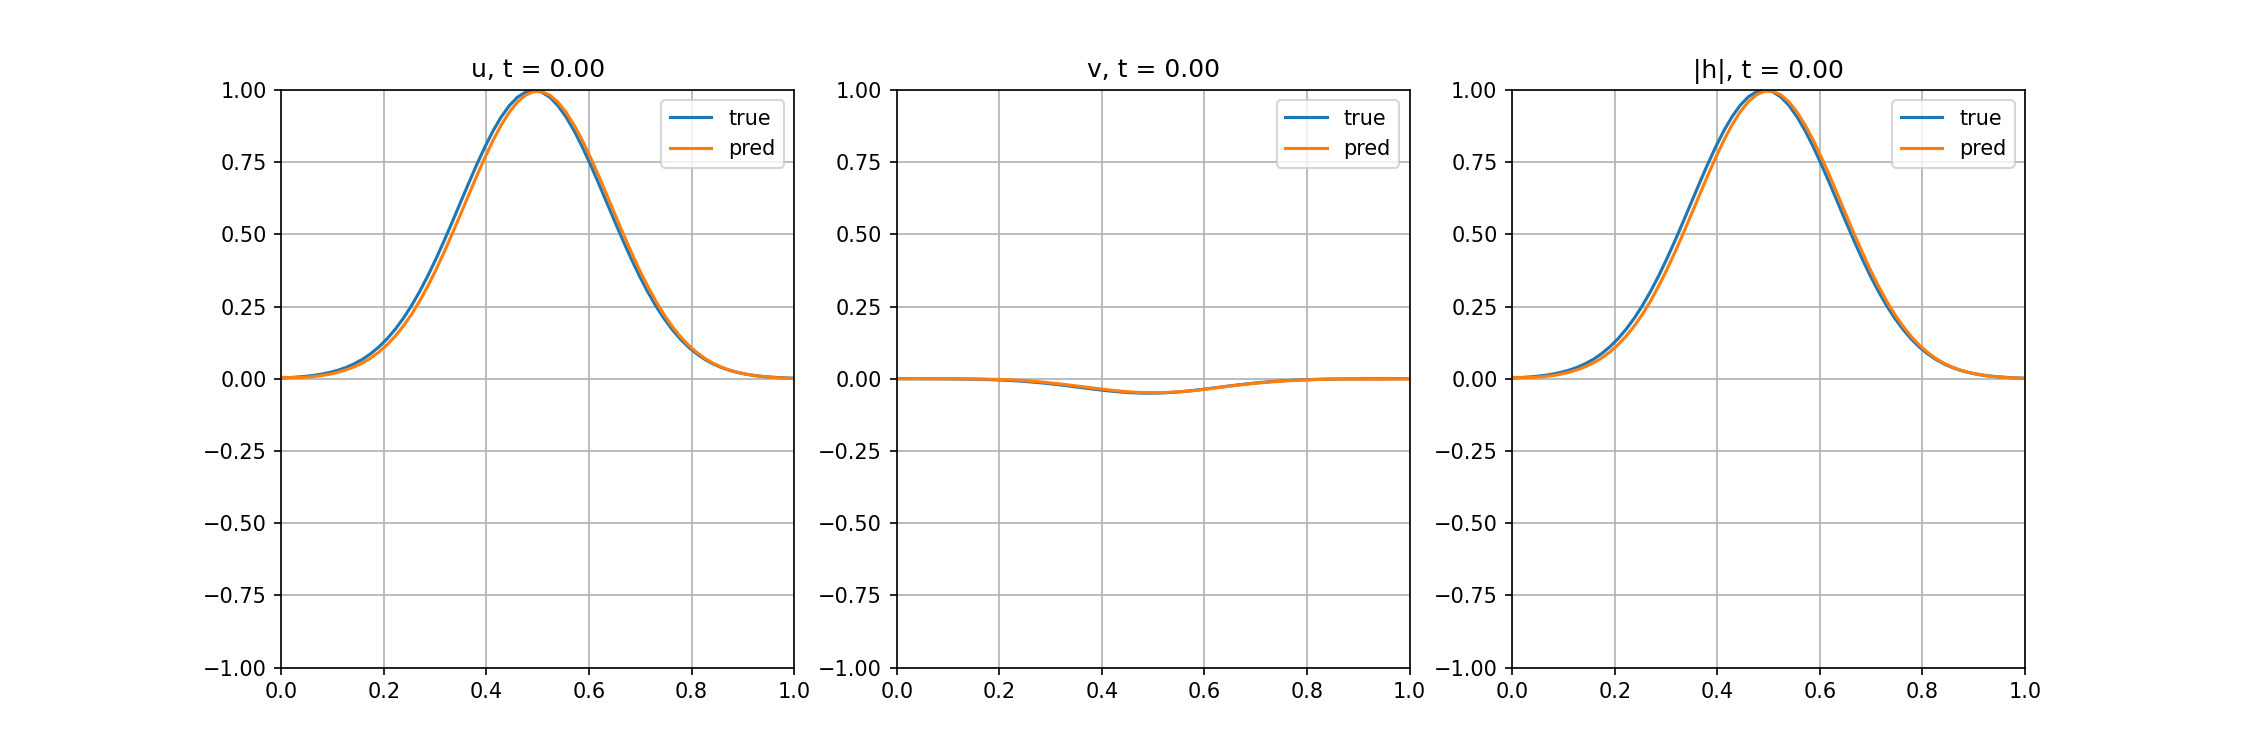

In [45]:
from scipy.io import loadmat

uv_true = loadmat("epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 64)
t_test = jnp.linspace(*domain[:, 1], 101)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

In [39]:
uv_true.shape

(64, 101)